# <font color="#0b486b">  FIT5215: Deep Learning (2024) - Assignment 2 (RNNs)</font>
***
*CE/Lecturer (Clayton):*  **Dr Trung Le** | trunglm@monash.edu <br/>
*Lecturer (Clayton):* **Prof Dinh Phung** | dinh.phung@monash.edu <br/>
*Lecturer (Malaysia):*  **Dr Arghya Pal** | arghya.pal@monash.edu <br/>
*Lecturer (Malaysia):*  **Dr Lim Chern Hong** | lim.chernhong@monash.edu <br/>  <br/>
*Head Tutor 3181:*  **Miss Vy Vo** |  \[v.vo@monash.edu \] <br/>
*Head Tutor 5215:*  **Dr Van Nguyen** |  \[van.nguyen1@monash.edu \]

<br/>
Faculty of Information Technology, Monash University, Australia

# <font color="#0b486b">  Student Information</font>
***
Surname: **[Kim]**  <br/>
Firstname: **[Jee Eun]**    <br/>
Student ID: **[34207147]**    <br/>
Email: **[jkim0094@student.monash.edu]**    <br/>
Your tutorial time: **[THU 16:00-18:00]**    <br/>
***

# <font color="0b486b">Assignment 2 – Deep Learning for Sequential Data</font>
### Due: <font color="red">11:55pm Sunday, 20 October 2024</font> (FIT5215)

#### <font color="red">Important note:</font> This is an **individual** assignment. It contributes **20%** to your final mark. Read the assignment instructions carefully.

## <font color="#0b486b">Assignment 2's Organization</font>
This assignment 2 has two (2) sections:
- Section 1: Fundamentals of RNNs (10 marks).
- Section 2: Deep Learning for Sequential Data (90 marks). This section is further divided into 4 parts.

The assignment 2 is organized in three (3) notebooks:
- Notebook 1 ([link](https://colab.research.google.com/drive/1hTS6bWz6gU-lvi1qkIhrtQnJ3tzxRPFK?usp=sharing)) [Total: 30 marks] includes Section 1 as well as Part 1 and Part 2 of Section 2.
- Notebook 2 (this notebook) [Total: 40 marks] includes Part 3 of Section 2.
- Notebook 3 ([link](https://colab.research.google.com/drive/1JfMZeCkkvjZ5LvKNV-UnR10pl-RogMgF?usp=sharing)) [Total: 30 marks] includes Part 4 of Section 2.


## <font color="#0b486b">What to submit</font>

This assignment is to be completed individually and submitted to Moodle unit site. **By the due date, you are required to submit one  <font color="red; font-weight:bold">single zip file, named xxx_assignment02_solution.zip</font> where `xxx` is your student ID, to the corresponding Assignment (Dropbox) in Moodle**. You can use Google Colab to do Assignment 2 but you need to save it to an `*.ipynb` file to submit to the unit Moodle.

**More importantly, if you use Google Colab to do this assignment, you need to first make a copy of this notebook on your Google drive**.

***For example, if your student ID is <font color="red; font-weight:bold">12356</font>, then gather all of your assignment solutions to a folder, create a zip file named <font color="red; font-weight:bold">123456_assignment02_solution.zip</font> and submit this file.***

Within this zip folder, you **must** submit the following files <u>for each part</u>:
1.	**`FIT5215_DeepLearning_Assignment2_Official[Main].ipynb`**:  this is your Python notebook solution source file.
1.	**`FIT5215_DeepLearning_Assignment2_Official[Main].html`**: this is the output of your Python notebook solution *exported* in HTML format.
1. **`FIT5215_DeepLearning_Assignment2_Official[RNNs].ipynb`**
1. **`FIT5215_DeepLearning_Assignment2_Official[RNNs].html`**
1. **`FIT5215_DeepLearning_Assignment2_Official[Transformers].ipynb`**
1. **`FIT5215_DeepLearning_Assignment2_Official[Transformers].html`**
1.	Any **extra files or folder** needed to complete your assignment (e.g., images used in your answers).



## Section 2: Deep Learning for Sequential Data

### <font color="#0b486b">Set random seeds</font>

We start with importing PyTorch and NumPy and setting random seeds for PyTorch and NumPy. You can use any seeds you prefer.

In [1]:
import os
import torch
import random
import requests
import pandas as pd
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer
import os
from six.moves.urllib.request import urlretrieve
from sklearn import preprocessing
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
def seed_all(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_all(seed=1234)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## <font color="#0b486b">Download and preprocess the data</font>

<div style="text-align: right"><font color="red; font-weight:bold"><span></div>

The dataset we use for this assignment is a question classification dataset for which the training set consists of $5,500$ questions belonging to 6 coarse question categories including:
- abbreviation (ABBR),
- entity (ENTY),
- description (DESC),
- human (HUM),
- location (LOC) and
- numeric (NUM).

In this assignment, we will utilize a subset of this dataset, containing $2,000$ questions for training and validation. We will use 80% of those 2000 questions for trainning and the rest for validation.


Preprocessing data is a crucial initial step in any machine learning or deep learning project. The *TextDataManager* class simplifies the process by providing functionalities to download and preprocess data specifically designed for the subsequent questions in this assignment. It is highly recommended to gain a comprehensive understanding of the class's functionality by **carefully reading** the content provided in the *TextDataManager* class before proceeding to answer the questions.

In [3]:
class DataManager:
    """
    This class manages and preprocesses a simple text dataset for a sentence classification task.

    Attributes:
        verbose (bool): Controls verbosity for printing information during data processing.
        max_sentence_len (int): The maximum length of a sentence in the dataset.
        str_questions (list): A list to store the string representations of the questions in the dataset.
        str_labels (list): A list to store the string representations of the labels in the dataset.
        numeral_labels (list): A list to store the numerical representations of the labels in the dataset.
        numeral_data (list): A list to store the numerical representations of the questions in the dataset.
        random_state (int): Seed value for random number generation to ensure reproducibility.
            Set this value to a specific integer to reproduce the same random sequence every time. Defaults to 6789.
        random (np.random.RandomState): Random number generator object initialized with the given random_state.
            It is used for various random operations in the class.

    Methods:
        maybe_download(dir_name, file_name, url, verbose=True):
            Downloads a file from a given URL if it does not exist in the specified directory.
            The directory and file are created if they do not exist.

        read_data(dir_name, file_names):
            Reads data from files in a directory, preprocesses it, and computes the maximum sentence length.
            Each file is expected to contain rows in the format "<label>:<question>".
            The labels and questions are stored as string representations.

        manipulate_data():
            Performs data manipulation by tokenizing, numericalizing, and padding the text data.
            The questions are tokenized and converted into numerical sequences using a tokenizer.
            The sequences are padded or truncated to the maximum sequence length.

        train_valid_test_split(train_ratio=0.9):
            Splits the data into training, validation, and test sets based on a given ratio.
            The data is randomly shuffled, and the specified ratio is used to determine the size of the training set.
            The string questions, numerical data, and numerical labels are split accordingly.
            TensorFlow `Dataset` objects are created for the training and validation sets.


    """

    def __init__(self, verbose=True, random_state=6789):
        self.verbose = verbose
        self.max_sentence_len = 0
        self.str_questions = list()
        self.str_labels = list()
        self.numeral_labels = list()
        self.maxlen = None
        self.numeral_data = list()
        self.random_state = random_state
        self.random = np.random.RandomState(random_state)

    @staticmethod
    def maybe_download(dir_name, file_name, url, verbose=True):
        if not os.path.exists(dir_name):
            os.mkdir(dir_name)
        if not os.path.exists(os.path.join(dir_name, file_name)):
            urlretrieve(url + file_name, os.path.join(dir_name, file_name))
        if verbose:
            print("Downloaded successfully {}".format(file_name))

    def read_data(self, dir_name, file_names):
        self.str_questions = list()
        self.str_labels = list()
        for file_name in file_names:
            file_path= os.path.join(dir_name, file_name)
            with open(file_path, "r", encoding="latin-1") as f:
                for row in f:
                    row_str = row.split(":")
                    label, question = row_str[0], row_str[1]
                    question = question.lower()
                    self.str_labels.append(label)
                    self.str_questions.append(question[0:-1])
                    if self.max_sentence_len < len(self.str_questions[-1]):
                        self.max_sentence_len = len(self.str_questions[-1])

        # turns labels into numbers
        le = preprocessing.LabelEncoder()
        le.fit(self.str_labels)
        self.numeral_labels = np.array(le.transform(self.str_labels))
        self.str_classes = le.classes_
        self.num_classes = len(self.str_classes)
        if self.verbose:
            print("\nSample questions and corresponding labels... \n")
            print(self.str_questions[0:5])
            print(self.str_labels[0:5])

    def manipulate_data(self):
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        vocab = self.tokenizer.get_vocab()
        self.word2idx = {w: i for i, w in enumerate(vocab)}
        self.idx2word = {i:w for w,i in self.word2idx.items()}
        self.vocab_size = len(self.word2idx)

        token_ids = []
        num_seqs = []
        for text in self.str_questions:  # iterate over the list of text
          text_seqs = self.tokenizer.tokenize(str(text))  # tokenize each text individually
          # Convert tokens to IDs
          token_ids = self.tokenizer.convert_tokens_to_ids(text_seqs)
          # Convert token IDs to a tensor of indices using your word2idx mapping
          seq_tensor = torch.LongTensor(token_ids)
          num_seqs.append(seq_tensor)  # append the tensor for each sequence

        # Pad the sequences and create a tensor
        if num_seqs:
          self.numeral_data = pad_sequence(num_seqs, batch_first=True)  # Pads to max length of the sequences
          self.num_sentences, self.maxlen = self.numeral_data.shape

    def train_valid_test_split(self, train_ratio=0.8, test_ratio = 0.1):
        train_size = int(self.num_sentences*train_ratio) +1
        test_size = int(self.num_sentences*test_ratio) +1
        valid_size = self.num_sentences - (train_size + test_size)
        data_indices = list(range(self.num_sentences))
        random.shuffle(data_indices)
        self.train_str_questions = [self.str_questions[i] for i in data_indices[:train_size]]
        self.train_numeral_labels = self.numeral_labels[data_indices[:train_size]]
        train_set_data = self.numeral_data[data_indices[:train_size]]
        train_set_labels = self.numeral_labels[data_indices[:train_size]]
        train_set_labels = torch.from_numpy(train_set_labels)
        train_set = torch.utils.data.TensorDataset(train_set_data, train_set_labels)
        self.test_str_questions = [self.str_questions[i] for i in data_indices[-test_size:]]
        self.test_numeral_labels = self.numeral_labels[data_indices[-test_size:]]
        test_set_data = self.numeral_data[data_indices[-test_size:]]
        test_set_labels = self.numeral_labels[data_indices[-test_size:]]
        test_set_labels = torch.from_numpy(test_set_labels)
        test_set = torch.utils.data.TensorDataset(test_set_data, test_set_labels)
        self.valid_str_questions = [self.str_questions[i] for i in data_indices[train_size:-test_size]]
        self.valid_numeral_labels = self.numeral_labels[data_indices[train_size:-test_size]]
        valid_set_data = self.numeral_data[data_indices[train_size:-test_size]]
        valid_set_labels = self.numeral_labels[data_indices[train_size:-test_size]]
        valid_set_labels = torch.from_numpy(valid_set_labels)
        valid_set = torch.utils.data.TensorDataset(valid_set_data, valid_set_labels)
        self.train_loader = DataLoader(train_set, batch_size=64, shuffle=True) # you can change the batch size if needed
        self.test_loader = DataLoader(test_set, batch_size=64, shuffle=False) # you can change the batch size if needed
        self.valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False) # you can change the batch size if needed

In [4]:
print('Loading data...')
DataManager.maybe_download("data", "train_2000.label", "http://cogcomp.org/Data/QA/QC/")

dm = DataManager()
dm.read_data("data/", ["train_2000.label"])

Loading data...
Downloaded successfully train_2000.label

Sample questions and corresponding labels... 

['manner how did serfdom develop in and then leave russia ?', 'cremat what films featured the character popeye doyle ?', "manner how can i find a list of celebrities ' real names ?", 'animal what fowl grabs the spotlight after the chinese year of the monkey ?', 'exp what is the full form of .com ?']
['DESC', 'ENTY', 'DESC', 'ENTY', 'ABBR']


In [5]:
dm.manipulate_data()
dm.train_valid_test_split(train_ratio=0.8, test_ratio = 0.1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
for x, y in dm.train_loader:
    print(x.shape, y.shape)
    break

torch.Size([64, 36]) torch.Size([64])


We now declare the `BaseTrainer` class, which will be used later to train the subsequent deep learning models for text data.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class BaseTrainer:
    def __init__(self, model, criterion, optimizer, train_loader, val_loader):
        self.model = model
        self.criterion = criterion  #the loss function
        self.optimizer = optimizer  #the optimizer
        self.train_loader = train_loader  #the train loader
        self.val_loader = val_loader  #the valid loader

    #the function to train the model in many epochs
    def fit(self, num_epochs):
        self.num_batches = len(self.train_loader)

        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')
            train_loss, train_accuracy = self.train_one_epoch()
            val_loss, val_accuracy = self.validate_one_epoch()
            print(
                f'{self.num_batches}/{self.num_batches} - train_loss: {train_loss:.4f} - train_accuracy: {train_accuracy*100:.4f}% \
                - val_loss: {val_loss:.4f} - val_accuracy: {val_accuracy*100:.4f}%')

    #train in one epoch, return the train_acc, train_loss
    def train_one_epoch(self):
        self.model.train()
        running_loss, correct, total = 0.0, 0, 0
        for i, data in enumerate(self.train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_accuracy = correct / total
        train_loss = running_loss / self.num_batches
        return train_loss, train_accuracy

    #evaluate on a loader and return the loss and accuracy
    def evaluate(self, loader):
        self.model.eval()
        loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for data in loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        loss = loss / len(self.val_loader)
        return loss, accuracy

    #return the val_acc, val_loss, be called at the end of each epoch
    def validate_one_epoch(self):
      val_loss, val_accuracy = self.evaluate(self.val_loader)
      return val_loss, val_accuracy

## <font color="#0b486b">Part 3: RNN-based models for sequence modeling and neural embedding</font>

<div style="text-align: right"><font color="red; font-weight:bold">[Total marks for this part: 40 marks]<span></div>

### <font color="#0b486b">3.1. RNNs with different cell types</font> ###

<div style="text-align: right"><font color="red; font-weight:bold">[Total marks for this part: 16 marks]<span></div>

#### <font color="red">**Question 3.1.1**</font>
**In this part, you need to construct a vanilla RNN using PyTorch to learn from the dataset of interest. Basically, you are required to construct the class `BaseRNN` with the following requirements:**
- Attribute `data_manager (self.data_manager)`: specifies the data manager used to store data for the model.
- Attribute `cell_type (self.cell_type)`: can take one of the three values, i.e., `simple_rnn`, `gru`, or `lstm` which specifies the memory cells formed a hidden layer.
- `state_sizes (self.state_sizes)` indicates the list of the hidden sizes  of memory cells. For example, $state\_sizes = [64, 128]$ means that you have two hidden layers in your network with hidden sizes of $64$ and $128$ respectively.
- The `build` method/function aims to build the architecture of our RNNs.
- Attribute `output_type (self.output_type)` has three values which are `"last_state"`, `"mean"`, or `"max"`, indicating we use the last hidden state, the mean of all hidden states, or the max of all hidden states on the last RNN hidden layer for gaining the 2D tensor $\left[batch\_size, state\_sizes[-1] \right]$ on which we conduct one linear layer for making prediction.   

<div style="text-align: right"><font color="red">[10 marks]</font></div>

In [8]:
class BaseRNN(nn.Module):
    def __init__(self, cell_type='gru', embed_size=128, state_sizes=[128, 128], output_type="mean", data_manager=None):
        super().__init__()
        self.cell_type = cell_type  # Type of RNN cell (gru, lstm, simple_rnn)
        self.state_sizes = state_sizes  # List of hidden layer sizes
        self.embed_size = embed_size  # Embedding vector size
        self.output_type = output_type  # Type of output (last_state, mean, max)
        self.data_manager = data_manager  # Data manager to handle data
        self.vocab_size = self.data_manager.vocab_size  # Vocabulary size from data manager

        # Build the network architecture
        self.build()

    # Static method to return the corresponding RNN layer
    @staticmethod
    def get_layer(cell_type='gru', input_size=128, state_size=128):
        if cell_type == 'gru':
            return nn.GRU(input_size=input_size, hidden_size=state_size, batch_first=True)
        elif cell_type == 'lstm':
            return nn.LSTM(input_size=input_size, hidden_size=state_size, batch_first=True)
        else:  # simple RNN
            return nn.RNN(input_size=input_size, hidden_size=state_size, batch_first=True)

    # Method to build the RNN architecture
    def build(self):
        # Create the embedding layer
        self.embedding = nn.Embedding(self.vocab_size, self.embed_size)

        # Create RNN layers and store them in a ModuleList
        layers = []
        input_size = self.embed_size
        for state_size in self.state_sizes:
            layers.append(self.get_layer(self.cell_type, input_size=input_size, state_size=state_size))
            input_size = state_size  # Update input size for the next RNN layer

        # Register the RNN layers as a ModuleList
        self.rnn_layers = nn.ModuleList(layers)

        # Fully connected layer for final prediction
        self.fc = nn.Linear(self.state_sizes[-1], self.data_manager.num_classes)

    # Forward pass of the model
    def forward(self, x):
        # embedding layer to the input
        x = self.embedding(x)

        # Apply RNN layers sequentially
        for rnn_layer in self.rnn_layers:
            x, _ = rnn_layer(x)  # RNN layers return (output, hidden_state), we use output

        # Select the final output type
        if self.output_type == "last_state":
            x = x[:, -1, :]  # Type of output : last_state
        elif self.output_type == "mean":
            x = torch.mean(x, dim=1)  # Type of output : mean
        elif self.output_type == "max":
            x, _ = torch.max(x, dim=1)  # Type of output : maximum
        else:
            raise ValueError("Invalid output_type. Choose from 'last_state', 'mean', or 'max'.")

        # Pass the result through the fully connected layer for prediction
        x = self.fc(x)
        return x


#### <font color="red">**Question 3.1.2**</font>
**Train the models with simple RNN ('simple_rnn') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$ and with three ouput types.**

<div style="text-align: right"><font color="red">[2 marks]</font></div>

a) For `output_type = "mean"`

In [14]:
#Insert your code here
base_rnn = BaseRNN(
    cell_type='simple_rnn',
    embed_size=128,
    state_sizes=[64, 128],
    output_type="mean",
    data_manager=dm
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(base_rnn.parameters(), lr=0.001)
base_rnn.to(device)
print(base_rnn)

BaseRNN(
  (embedding): Embedding(30522, 128)
  (rnn_layers): ModuleList(
    (0): RNN(128, 64, batch_first=True)
    (1): RNN(64, 128, batch_first=True)
  )
  (fc): Linear(in_features=128, out_features=6, bias=True)
)


In [15]:
trainer = BaseTrainer(model= base_rnn, criterion=criterion, optimizer=optimizer, train_loader=dm.train_loader, val_loader=dm.valid_loader)
trainer.fit(num_epochs=30)

Epoch 1/30
26/26 - train_loss: 1.6520 - train_accuracy: 25.7339%                 - val_loss: 0.6962 - val_accuracy: 28.2828%
Epoch 2/30
26/26 - train_loss: 1.4124 - train_accuracy: 39.7876%                 - val_loss: 0.5626 - val_accuracy: 53.5354%
Epoch 3/30
26/26 - train_loss: 1.0876 - train_accuracy: 52.6546%                 - val_loss: 0.4776 - val_accuracy: 63.6364%
Epoch 4/30
26/26 - train_loss: 1.1543 - train_accuracy: 58.9631%                 - val_loss: 0.2744 - val_accuracy: 68.6869%
Epoch 5/30
26/26 - train_loss: 0.8683 - train_accuracy: 63.9600%                 - val_loss: 0.3862 - val_accuracy: 70.2020%
Epoch 6/30
26/26 - train_loss: 0.7664 - train_accuracy: 65.4591%                 - val_loss: 0.3226 - val_accuracy: 70.2020%
Epoch 7/30
26/26 - train_loss: 0.7140 - train_accuracy: 68.2698%                 - val_loss: 0.3415 - val_accuracy: 82.8283%
Epoch 8/30
26/26 - train_loss: 0.6524 - train_accuracy: 64.5222%                 - val_loss: 0.2615 - val_accuracy: 74.2424%


b) For `output_type = "max"`

In [16]:
#Insert your code here
base_rnn = BaseRNN(
    cell_type='simple_rnn',
    embed_size=128,
    state_sizes=[64, 128],
    output_type="max",
    data_manager=dm
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(base_rnn.parameters(), lr=0.001)
base_rnn.to(device)
base_rnn

BaseRNN(
  (embedding): Embedding(30522, 128)
  (rnn_layers): ModuleList(
    (0): RNN(128, 64, batch_first=True)
    (1): RNN(64, 128, batch_first=True)
  )
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [17]:
trainer = BaseTrainer(model= base_rnn, criterion=criterion, optimizer=optimizer, train_loader=dm.train_loader, val_loader=dm.valid_loader)
trainer.fit(num_epochs=30)

Epoch 1/30
26/26 - train_loss: 1.5222 - train_accuracy: 42.8482%                 - val_loss: 0.5502 - val_accuracy: 79.2929%
Epoch 2/30
26/26 - train_loss: 0.8631 - train_accuracy: 86.1961%                 - val_loss: 0.2229 - val_accuracy: 92.4242%
Epoch 3/30
26/26 - train_loss: 0.4400 - train_accuracy: 91.1930%                 - val_loss: 0.1162 - val_accuracy: 93.9394%
Epoch 4/30
26/26 - train_loss: 0.2776 - train_accuracy: 92.4422%                 - val_loss: 0.0619 - val_accuracy: 93.4343%
Epoch 5/30
26/26 - train_loss: 0.1923 - train_accuracy: 93.2542%                 - val_loss: 0.0412 - val_accuracy: 93.4343%
Epoch 6/30
26/26 - train_loss: 0.1483 - train_accuracy: 95.0031%                 - val_loss: 0.0272 - val_accuracy: 95.4545%
Epoch 7/30
26/26 - train_loss: 0.1217 - train_accuracy: 95.9400%                 - val_loss: 0.0209 - val_accuracy: 93.9394%
Epoch 8/30
26/26 - train_loss: 0.1032 - train_accuracy: 96.6271%                 - val_loss: 0.0141 - val_accuracy: 94.4444%


c) For `output_type = "last_state"`

In [18]:
#Insert your code here
base_rnn = BaseRNN(
    cell_type='simple_rnn',
    embed_size=128,
    state_sizes=[64, 128],
    output_type="last_state",
    data_manager=dm
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(base_rnn.parameters(), lr=0.001)

base_rnn.to(device)

base_rnn

BaseRNN(
  (embedding): Embedding(30522, 128)
  (rnn_layers): ModuleList(
    (0): RNN(128, 64, batch_first=True)
    (1): RNN(64, 128, batch_first=True)
  )
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [19]:
trainer = BaseTrainer(model= base_rnn, criterion=criterion, optimizer=optimizer, train_loader=dm.train_loader, val_loader=dm.valid_loader)
trainer.fit(num_epochs=30)

Epoch 1/30
26/26 - train_loss: 1.6744 - train_accuracy: 23.3604%                 - val_loss: 0.8295 - val_accuracy: 26.2626%
Epoch 2/30
26/26 - train_loss: 1.6674 - train_accuracy: 22.6109%                 - val_loss: 0.7497 - val_accuracy: 27.2727%
Epoch 3/30
26/26 - train_loss: 1.6584 - train_accuracy: 21.6740%                 - val_loss: 0.7337 - val_accuracy: 27.2727%
Epoch 4/30
26/26 - train_loss: 1.6616 - train_accuracy: 20.4872%                 - val_loss: 0.7579 - val_accuracy: 18.1818%
Epoch 5/30
26/26 - train_loss: 1.6583 - train_accuracy: 22.0487%                 - val_loss: 0.7942 - val_accuracy: 27.2727%
Epoch 6/30
26/26 - train_loss: 1.6536 - train_accuracy: 23.4229%                 - val_loss: 0.7659 - val_accuracy: 27.2727%
Epoch 7/30
26/26 - train_loss: 1.6582 - train_accuracy: 24.3598%                 - val_loss: 0.8185 - val_accuracy: 26.2626%
Epoch 8/30
26/26 - train_loss: 1.6569 - train_accuracy: 23.4853%                 - val_loss: 0.7768 - val_accuracy: 27.2727%


#### <font color="red">**Question 3.1.3**</font>
**Train the models with LSTM ('lstm') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$ and with three ouput types.** You should follow the structure of Question 3.1.2.

<div style="text-align: right"><font color="red">[2 marks]</font></div>

In [21]:
#Insert your code here
lstm_rnn = BaseRNN(
    cell_type='lstm',
    embed_size=128,
    state_sizes=[64, 128],
    output_type="mean",
    data_manager=dm
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_rnn.parameters(), lr=0.001)

lstm_rnn.to(device)

trainer = BaseTrainer(model=lstm_rnn, criterion=criterion, optimizer=optimizer, train_loader=dm.train_loader, val_loader=dm.valid_loader)
trainer.fit(num_epochs=30)


Epoch 1/30
26/26 - train_loss: 1.6808 - train_accuracy: 24.4222%                 - val_loss: 0.7585 - val_accuracy: 21.7172%
Epoch 2/30
26/26 - train_loss: 1.6241 - train_accuracy: 27.9825%                 - val_loss: 0.7468 - val_accuracy: 38.8889%
Epoch 3/30
26/26 - train_loss: 1.1127 - train_accuracy: 61.6490%                 - val_loss: 0.1728 - val_accuracy: 79.2929%
Epoch 4/30
26/26 - train_loss: 0.5148 - train_accuracy: 88.2573%                 - val_loss: 0.0582 - val_accuracy: 90.9091%
Epoch 5/30
26/26 - train_loss: 0.2910 - train_accuracy: 91.9425%                 - val_loss: 0.0378 - val_accuracy: 90.4040%
Epoch 6/30
26/26 - train_loss: 0.2468 - train_accuracy: 92.9419%                 - val_loss: 0.0248 - val_accuracy: 93.4343%
Epoch 7/30
26/26 - train_loss: 0.2225 - train_accuracy: 93.7539%                 - val_loss: 0.0246 - val_accuracy: 91.9192%
Epoch 8/30
26/26 - train_loss: 0.1916 - train_accuracy: 94.6908%                 - val_loss: 0.0213 - val_accuracy: 91.9192%


In [22]:
#Insert your code here
lstm_rnn = BaseRNN(
    cell_type='lstm',
    embed_size=128,
    state_sizes=[64, 128],
    output_type="max",
    data_manager=dm
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_rnn.parameters(), lr=0.001)

lstm_rnn.to(device)

trainer = BaseTrainer(model=lstm_rnn, criterion=criterion, optimizer=optimizer, train_loader=dm.train_loader, val_loader=dm.valid_loader)
trainer.fit(num_epochs=30)


Epoch 1/30
26/26 - train_loss: 1.6687 - train_accuracy: 29.7939%                 - val_loss: 0.7527 - val_accuracy: 54.0404%
Epoch 2/30
26/26 - train_loss: 1.2579 - train_accuracy: 55.0281%                 - val_loss: 0.3546 - val_accuracy: 80.3030%
Epoch 3/30
26/26 - train_loss: 0.5639 - train_accuracy: 80.5122%                 - val_loss: 0.1278 - val_accuracy: 89.8990%
Epoch 4/30
26/26 - train_loss: 0.2712 - train_accuracy: 92.0675%                 - val_loss: 0.0397 - val_accuracy: 93.9394%
Epoch 5/30
26/26 - train_loss: 0.1574 - train_accuracy: 94.1911%                 - val_loss: 0.0172 - val_accuracy: 94.9495%
Epoch 6/30
26/26 - train_loss: 0.1159 - train_accuracy: 95.7527%                 - val_loss: 0.0110 - val_accuracy: 95.4545%
Epoch 7/30
26/26 - train_loss: 0.0973 - train_accuracy: 97.3142%                 - val_loss: 0.0080 - val_accuracy: 95.4545%
Epoch 8/30
26/26 - train_loss: 0.0735 - train_accuracy: 97.6889%                 - val_loss: 0.0061 - val_accuracy: 95.9596%


In [23]:
#Insert your code here
lstm_rnn = BaseRNN(
    cell_type='lstm',
    embed_size=128,
    state_sizes=[64, 128],
    output_type="last_state",
    data_manager=dm
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_rnn.parameters(), lr=0.001)

lstm_rnn.to(device)

trainer = BaseTrainer(model=lstm_rnn, criterion=criterion, optimizer=optimizer, train_loader=dm.train_loader, val_loader=dm.valid_loader)
trainer.fit(num_epochs=30)


Epoch 1/30
26/26 - train_loss: 1.6802 - train_accuracy: 21.6115%                 - val_loss: 0.7560 - val_accuracy: 27.2727%
Epoch 2/30
26/26 - train_loss: 1.6539 - train_accuracy: 23.4853%                 - val_loss: 0.7944 - val_accuracy: 26.2626%
Epoch 3/30
26/26 - train_loss: 1.6675 - train_accuracy: 21.6740%                 - val_loss: 0.7885 - val_accuracy: 26.2626%
Epoch 4/30
26/26 - train_loss: 1.6703 - train_accuracy: 21.9863%                 - val_loss: 0.7824 - val_accuracy: 27.2727%
Epoch 5/30
26/26 - train_loss: 1.6450 - train_accuracy: 23.4229%                 - val_loss: 0.7625 - val_accuracy: 27.2727%
Epoch 6/30
26/26 - train_loss: 1.6519 - train_accuracy: 23.7976%                 - val_loss: 0.7821 - val_accuracy: 26.2626%
Epoch 7/30
26/26 - train_loss: 1.6656 - train_accuracy: 22.4859%                 - val_loss: 0.7848 - val_accuracy: 27.2727%
Epoch 8/30
26/26 - train_loss: 1.6504 - train_accuracy: 23.8601%                 - val_loss: 0.7684 - val_accuracy: 27.2727%


#### <font color="red">**Question 3.1.4**</font>
**Train the models with GRU ('gru') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$ and with three ouput types.** You should follow the structure of Question 3.1.2.

<div style="text-align: right"><font color="red">[2 marks]</font></div>

In [25]:

#Insert your code here
gru_rnn = BaseRNN(
    cell_type='gru',
    embed_size=128,
    state_sizes=[64, 128],
    output_type="mean",
    data_manager=dm
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gru_rnn.parameters(), lr=0.001)

gru_rnn.to(device)

trainer = BaseTrainer(model=gru_rnn, criterion=criterion, optimizer=optimizer, train_loader=dm.train_loader, val_loader=dm.valid_loader)
trainer.fit(num_epochs=30)


Epoch 1/30
26/26 - train_loss: 1.6458 - train_accuracy: 26.5459%                 - val_loss: 0.7955 - val_accuracy: 26.2626%
Epoch 2/30
26/26 - train_loss: 1.5590 - train_accuracy: 31.4803%                 - val_loss: 0.5829 - val_accuracy: 56.0606%
Epoch 3/30
26/26 - train_loss: 0.8249 - train_accuracy: 77.5141%                 - val_loss: 0.1493 - val_accuracy: 90.9091%
Epoch 4/30
26/26 - train_loss: 0.2311 - train_accuracy: 92.9419%                 - val_loss: 0.0171 - val_accuracy: 93.9394%
Epoch 5/30
26/26 - train_loss: 0.1097 - train_accuracy: 96.1274%                 - val_loss: 0.0084 - val_accuracy: 95.9596%
Epoch 6/30
26/26 - train_loss: 0.0779 - train_accuracy: 97.3766%                 - val_loss: 0.0051 - val_accuracy: 96.9697%
Epoch 7/30
26/26 - train_loss: 0.0612 - train_accuracy: 98.0012%                 - val_loss: 0.0051 - val_accuracy: 96.4646%
Epoch 8/30
26/26 - train_loss: 0.0397 - train_accuracy: 98.9382%                 - val_loss: 0.0037 - val_accuracy: 96.4646%


In [26]:

#Insert your code here
gru_rnn = BaseRNN(
    cell_type='gru',
    embed_size=128,
    state_sizes=[64, 128],
    output_type="max",
    data_manager=dm
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gru_rnn.parameters(), lr=0.001)

gru_rnn.to(device)

trainer = BaseTrainer(model=gru_rnn, criterion=criterion, optimizer=optimizer, train_loader=dm.train_loader, val_loader=dm.valid_loader)
trainer.fit(num_epochs=30)




Epoch 1/30
26/26 - train_loss: 1.5688 - train_accuracy: 36.6021%                 - val_loss: 0.6366 - val_accuracy: 71.2121%
Epoch 2/30
26/26 - train_loss: 0.8950 - train_accuracy: 83.4478%                 - val_loss: 0.1912 - val_accuracy: 90.4040%
Epoch 3/30
26/26 - train_loss: 0.3082 - train_accuracy: 91.8801%                 - val_loss: 0.0304 - val_accuracy: 92.4242%
Epoch 4/30
26/26 - train_loss: 0.1586 - train_accuracy: 94.8157%                 - val_loss: 0.0165 - val_accuracy: 93.9394%
Epoch 5/30
26/26 - train_loss: 0.1197 - train_accuracy: 95.8151%                 - val_loss: 0.0106 - val_accuracy: 94.9495%
Epoch 6/30
26/26 - train_loss: 0.0766 - train_accuracy: 97.8139%                 - val_loss: 0.0076 - val_accuracy: 95.9596%
Epoch 7/30
26/26 - train_loss: 0.0443 - train_accuracy: 98.9382%                 - val_loss: 0.0046 - val_accuracy: 95.4545%
Epoch 8/30
26/26 - train_loss: 0.0363 - train_accuracy: 99.0631%                 - val_loss: 0.0032 - val_accuracy: 95.9596%


In [27]:

#Insert your code here
gru_rnn = BaseRNN(
    cell_type='gru',
    embed_size=128,
    state_sizes=[64, 128],
    output_type="last_state",
    data_manager=dm
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gru_rnn.parameters(), lr=0.001)

gru_rnn.to(device)

trainer = BaseTrainer(model=gru_rnn, criterion=criterion, optimizer=optimizer, train_loader=dm.train_loader, val_loader=dm.valid_loader)
trainer.fit(num_epochs=30)




Epoch 1/30
26/26 - train_loss: 1.6732 - train_accuracy: 21.6115%                 - val_loss: 0.8272 - val_accuracy: 18.1818%
Epoch 2/30
26/26 - train_loss: 1.6727 - train_accuracy: 23.5478%                 - val_loss: 0.8012 - val_accuracy: 26.2626%
Epoch 3/30
26/26 - train_loss: 1.6700 - train_accuracy: 23.4229%                 - val_loss: 0.7657 - val_accuracy: 27.2727%
Epoch 4/30
26/26 - train_loss: 1.6597 - train_accuracy: 21.6115%                 - val_loss: 0.7491 - val_accuracy: 28.2828%
Epoch 5/30
26/26 - train_loss: 1.6222 - train_accuracy: 28.8570%                 - val_loss: 0.7564 - val_accuracy: 34.8485%
Epoch 6/30
26/26 - train_loss: 1.4886 - train_accuracy: 41.8488%                 - val_loss: 0.5457 - val_accuracy: 49.4949%
Epoch 7/30
26/26 - train_loss: 0.9022 - train_accuracy: 65.1468%                 - val_loss: 0.3216 - val_accuracy: 69.6970%
Epoch 8/30
26/26 - train_loss: 0.5060 - train_accuracy: 80.0125%                 - val_loss: 0.5859 - val_accuracy: 78.2828%


### <font color="#0b486b">3.2. RNNs with fine-tuning embedding matrix</font> ###

<div style="text-align: right"><font color="red; font-weight:bold">[Total marks for this part: 12 marks]<span></div>

#### <font color="red">**Question 3.2.1**</font>

**In what follows, you are required to extend the class BaseRNN in Part 3.1 to achieve a class RNN in which the embedding matrix can be initialized using a pretrained Word2Vect.**

**Below are the descriptions of the attributes of the class *RNN*:**
- `run_mode (self.run_mode)` has three values (scratch, init-only, and init-fine-tune).
  - `scratch` means training the embedding matrix from scratch.
  - `init-only` means only initializing the embedding matrix with a pretrained Word2Vect but **not further doing** fine-tuning that matrix.
  - `init-fine-tune` means both initializing the embedding matrix with a pretrained Word2Vect and **further doing** fine-tuning that matrix.
- `cell_type (self.cell_type)` has three values (simple-rnn, gru, and lstm) which specify the memory cell used in the network.
- `embed_model (self.embed_model)` specifes the pretrained Word2Vect model used.
-  `embed_size (self.embed_size)` specifes the embedding size. Note that when run_mode is either 'init-only' or 'init-fine-tune', this embedding size is extracted from embed_model for dimension compatability.
- `state_sizes (self.state_sizes)` indicates the list of the hidden sizes  of memory cells. For example, $state\_sizes = [64, 128]$ means that you have two hidden layers in your network with hidden sizes of $64$ and $128$ respectively.

**Complete the code of the class *RNN*.**

<div style="text-align: right"><font color="red">[8 marks]</font></div>

In [28]:
import gensim.downloader as api
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import numpy as np

In [29]:
import torch
import torch.nn as nn
import numpy as np
import gensim.downloader as api

class RNN(BaseRNN):
    def __init__(self, cell_type='gru', embed_size=128, state_sizes=[128, 128], output_type="mean",
                 data_manager=None, run_mode='scratch', embed_model='glove-wiki-gigaword-100'):

        # Initialize the Word2Vec model and adjust the embedding size if not using 'scratch' mode
        if run_mode != 'scratch':
            self.word2vec = api.load(embed_model)  # Load pre-trained Word2Vec model using gensim
            embed_size = self.word2vec.vector_size  # Adjust the embedding size to Word2Vec vector size

        super().__init__(cell_type, embed_size, state_sizes, output_type, data_manager)

        self.run_mode = run_mode
        self.embed_model = embed_model
        self.embed_size = embed_size
        self.word2vec = None

        # Build the embedding matrix
        self.build_embedding_matrix()

        # Now call the build method to construct the architecture of the RNN
        self.replace_embedding()

    def build_embedding_matrix(self):
        vocab_size = len(self.data_manager.word2idx)  # Get vocabulary size from the data manager

        # Initialize the embedding matrix with random values (for 'scratch' mode)
        embed_matrix = np.random.randn(vocab_size, self.embed_size).astype(np.float32)

        # If not 'scratch', populate the embedding matrix with Word2Vec vectors
        if self.run_mode != 'scratch' and self.word2vec is not None:
            for word, idx in self.data_manager.word2idx.items():
                if word in self.word2vec:
                    embed_matrix[idx] = self.word2vec[word]  # Assign Word2Vec vector to the matrix

        # Initialize the nn.Embedding layer using the embedding matrix
        self.pretrained_embedding = nn.Embedding.from_pretrained(
            torch.tensor(embed_matrix),
            freeze=(self.run_mode == 'init-only')  # Freeze if 'init-only', otherwise allow fine-tuning
        )

    def replace_embedding(self):
        # Replace the embedding layer in the BaseRNN with the pretrained embedding
        self.embedding = self.pretrained_embedding


#### <font color="red">**Question 3.2.2**</font>

**Write code to conduct experiments to compare three running modes for the embedding matrix. Note that you should set fixed values for other attributes and only vary *run_mode*. Give your comments on the results.**

<div style="text-align: right"><font color="red">[4 marks]</font></div>

In [31]:

# Define fixed parameters
cell_type = 'gru_rnn'
embed_size = 128
state_sizes = [64, 128]
output_type = "mean"
embed_model = 'glove-wiki-gigaword-100'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_manager = dm

# Run modes to test
run_modes = ['scratch', 'init-only', 'init-fine-tune']
results = {}

# Loop over each run mode
for run_mode in run_modes:
    print(f"Training with run_mode = {run_mode}")

    rnn_model = RNN(
        cell_type=cell_type,
        embed_size=embed_size,
        state_sizes=state_sizes,
        output_type=output_type,
        data_manager=data_manager,
        run_mode=run_mode,
        embed_model=embed_model
    )
    rnn_model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001)

    trainer = BaseTrainer(
        model=rnn_model,
        criterion=criterion,
        optimizer=optimizer,
        train_loader=data_manager.train_loader,
        val_loader=data_manager.valid_loader
    )

    trainer.fit(num_epochs=30)

    train_loss, train_accuracy = trainer.train_one_epoch()
    val_loss, val_accuracy = trainer.validate_one_epoch()

    results[run_mode] = {
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy
    }

# Output the results
for mode, result in results.items():
    print(f"\nResults for {mode}:")
    print(f"Train Loss: {result['train_loss']:.4f}, Train Accuracy: {result['train_accuracy']*100:.2f}%")
    print(f"Validation Loss: {result['val_loss']:.4f}, Validation Accuracy: {result['val_accuracy']*100:.2f}%")


Training with run_mode = scratch
Epoch 1/30
26/26 - train_loss: 1.6774 - train_accuracy: 26.2336%                 - val_loss: 0.6701 - val_accuracy: 27.2727%
Epoch 2/30
26/26 - train_loss: 1.6048 - train_accuracy: 35.9151%                 - val_loss: 0.7009 - val_accuracy: 45.4545%
Epoch 3/30
26/26 - train_loss: 1.3009 - train_accuracy: 45.9713%                 - val_loss: 0.5908 - val_accuracy: 50.5051%
Epoch 4/30
26/26 - train_loss: 1.1389 - train_accuracy: 50.0937%                 - val_loss: 0.6082 - val_accuracy: 59.5960%
Epoch 5/30
26/26 - train_loss: 0.9915 - train_accuracy: 62.6483%                 - val_loss: 0.5337 - val_accuracy: 76.7677%
Epoch 6/30
26/26 - train_loss: 0.7763 - train_accuracy: 66.0837%                 - val_loss: 0.2515 - val_accuracy: 70.7071%
Epoch 7/30
26/26 - train_loss: 0.6252 - train_accuracy: 78.5134%                 - val_loss: 0.4221 - val_accuracy: 90.4040%
Epoch 8/30
26/26 - train_loss: 0.3477 - train_accuracy: 87.9450%                 - val_loss:

<b>Write your comments on the results here (maximum 150 words)</b>

**1. scratch** : In this mode, the embedding matrix is initialized randomly and then updated during training. Both training and validation showed high accuracy.

**2. init-only** : Pre-trained Word2Vec embeddings are used, but since the embeddings are frozen, the embedding matrix is not updated during training. As a result, this mode showed the lowest performance among the three. This suggests that the fixed embeddings were not optimized for the training data.

**3. init-fine-tune** : Pre-trained Word2Vec embeddings are used as a starting point, and the embedding matrix is updated during training. As a result, it showed much better performance compared to the init-only mode.

The good performance of both the scratch and init-fine-tune modes suggests that optimizing the embedding matrix for the training data is a key factor in achieving high performance.




### <font color="#0b486b">3.3. RNNs with Attention for Text and Sequence Classification</font> ###

**In what follows, you are required to implement a RNN with the attention mechanism for text and sequence classification. This attention mechanism is applied at the last hidden layer of our RNN. Specifically, let $\textbf{h}_1^L, \textbf{h}_2^L,...,\textbf{h}_{T-1}^L, \textbf{h}_T^L$ be the hidden states at the last hidden layer $L$ where $T$ is the sequence length. We compute the context vector $\textbf{c}$ as $\textbf{c}=\sum_{i=1}^{T}\textbf{a}_{i}\textbf{h}_{i}^L$ where $\textbf{a}_1,...,\textbf{a}_T$ are the alignment weights (i.e., $\textbf{a}_i\geq 0$ and $\sum_{i=1}^{T}\textbf{a}_{i}=1$).**

**The alignment weights are computed as follows:**
- $\textbf{a}=[\textbf{a}_{i}]_{i=1}^{T}=\text{softmax}(\textbf{s})$ where $\textbf{s}= [\textbf{s}_{i}]_{i=1}^{T}$ consists of the alignment scores.
- The alignment scores are computed as $\textbf{s}=\text{tanh}(\textbf{h}^LU)V$ where $\textbf{h}^L=\left[\begin{array}{c}
\textbf{h}_{1}^L\\
\textbf{h}_{2}^L\\
...\\
\textbf{h}_{T-1}^L\\
\textbf{h}_{T}^L
\end{array}\right]\in\mathbb{R}^{T\times state\_size_{L}}$, $U\in\mathbb{R}^{state\_size_{L}\times output\_length}$, $V\in\mathbb{R}^{output\_length\times1}$, and $output\_length$ is a hyperparameter. Note that if we consider a mini-batch, the shape of $\textbf{h}^L$ is $(batch\_size, T, state\_size_L)$ where $state\_size_L$ is the hidden size of the last hidden layer. The figure on the right below illustrates the process of calculating a score $\textbf{s}_i$ for an individual hidden state $\textbf{h}_i^L$. Weight matrices $U$ and $V$ are shared across the hidden states $\textbf{h}_1^L,\textbf{h}_2^L,\dots,\textbf{h}_T^L$.

**After having the context vector $\textbf{c}$, we concatenate with the output hidden state which is computed by aggregating $\textbf{h}^{1:T}_L$ following $3$ different `output_type` as above. On top of this concatenation, we conduct the output layer with the softmax activation.**

<div style="text-align: right"><font color="red; font-weight:bold">[Total marks for this part: 12 marks]<span></div>

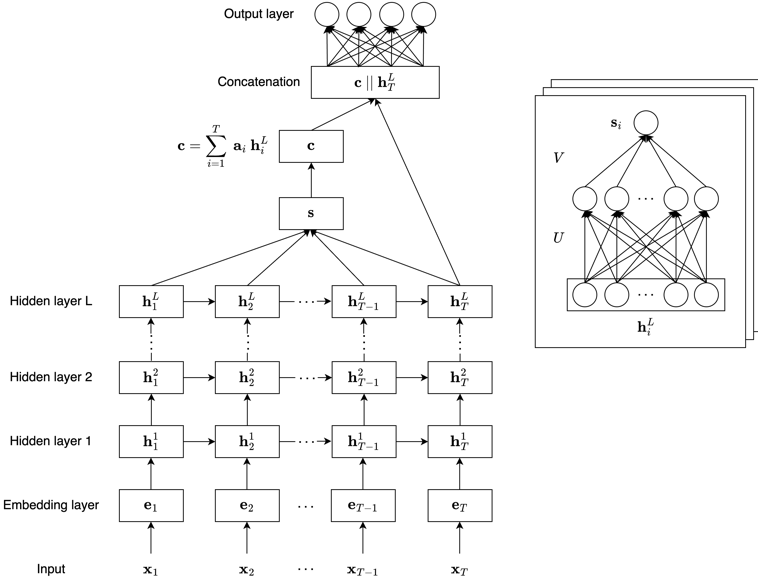

#### <font color="red">**Question 3.3.1**</font>

**We declare the  layer `MyAttention` to realize our attention mechanism. You are required to provide the code for this class. Note that in the `def forward(self, all_states, last_state)` method, `all_states` is the collection of all hidden states and `last_state` is the last hidden state.**

<div style="text-align: right"><font color="red">[4 marks]</font></div>

In [32]:
import torch.nn.functional as F

class MyAttention(nn.Module):
    def __init__(self, output_length=50, state_size=5):
        super(MyAttention, self).__init__()
        self.output_length = output_length
        self.U = nn.Linear(state_size, output_length)  # Linear transformation: (state_size, output_length)
        self.V = nn.Linear(output_length, 1, bias=False)  # Linear transformation: (output_length, 1)

    def forward(self, all_states, last_state):

        # Step 1: Calculate the alignment scores between the last hidden state and all hidden states
        last_state = last_state.unsqueeze(1)  # shape: (batch_size, 1, state_size)
        last_state_expanded = last_state.expand(-1, all_states.size(1), -1)  # shape: (batch_size, seq_length, state_size)

        # Calculate alignment scores (s_i)
        s = torch.tanh(self.U(all_states) + self.U(last_state_expanded))  # shape: (batch_size, seq_length, output_length)
        alignment_scores = self.V(s).squeeze(-1)  # shape: (batch_size, seq_length)

        # Step 2: Calculate attention weights using softmax
        attention_weights = F.softmax(alignment_scores, dim=-1)  # shape: (batch_size, seq_length)

        # Step 3: Calculate the context vector using the attention weights
        context_vector = torch.sum(attention_weights.unsqueeze(-1) * all_states, dim=1)  # shape: (batch_size, state_size)

        return context_vector


We now test `MyAttention`.

In [33]:
batch_size = 10
seq_length = 20
state_size = 5
all_states = torch.randn(batch_size, seq_length, state_size).to(device)
last_state = all_states[:, -1, :].to(device)
attention = MyAttention()
context_vector = attention(all_states, last_state)
print(all_states.shape)
print(last_state.shape)
print(context_vector.shape)

torch.Size([10, 20, 5])
torch.Size([10, 5])
torch.Size([10, 5])


#### <font color="red">**Question 3.3.2**</font>

**You are required to extend the class `BaseRNN` in Question `3.2.1` to achieve the class `AttentionRNN` in which the attention mechanism mentioned above is applied at the last hidden layer.**

<div style="text-align: right"><font color="red">[6 marks]</font></div>

In [34]:
class AttentionRNN(BaseRNN):
    def __init__(self, cell_type='gru', embed_size=128, state_sizes=[128, 128], output_type="mean", data_manager=None):
        super().__init__(cell_type, embed_size, state_sizes, output_type, data_manager)
        # Get the state size of the last hidden layer
        last_state_size = self.state_sizes[-1]
        # Add an Attention Layer to apply the attention mechanism
        self.attention = MyAttention(output_length=last_state_size, state_size=last_state_size)

    def forward(self, x):
        # Convert input data through the embedding layer
        x = self.embedding(x)

        # Apply RNN layers
        for rnn_layer in self.rnn_layers:
            x, hidden_states = rnn_layer(x)  # Get output from RNN layers

        # Apply the attention mechanism to the last hidden state
        last_hidden_state = hidden_states[-1]  # Get the last hidden state's output
        context_vector = self.attention(x, last_hidden_state)  # Apply attention mechanism

        # Pass the result through the fully connected layer
        x = self.fc(context_vector)
        return x


#### <font color="red">**Question 3.3.3**</font>

**Conduct the experiment to test the above Attention RNN.**

<div style="text-align: right"><font color="red">[2 marks]</font></div>

In [36]:

attn_rnn = AttentionRNN(cell_type='gru', embed_size=128, state_sizes=[128, 128], output_type="mean", data_manager=dm).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(attn_rnn.parameters(), lr=0.001)
trainer = BaseTrainer(model=attn_rnn, criterion=criterion, optimizer=optimizer, train_loader=dm.train_loader, val_loader=dm.valid_loader)
trainer.fit(num_epochs=30)


Epoch 1/30
26/26 - train_loss: 1.6373 - train_accuracy: 29.1068%                 - val_loss: 0.6699 - val_accuracy: 64.6465%
Epoch 2/30
26/26 - train_loss: 0.8901 - train_accuracy: 75.9525%                 - val_loss: 0.1058 - val_accuracy: 89.8990%
Epoch 3/30
26/26 - train_loss: 0.2155 - train_accuracy: 93.2542%                 - val_loss: 0.0126 - val_accuracy: 94.9495%
Epoch 4/30
26/26 - train_loss: 0.1067 - train_accuracy: 96.3148%                 - val_loss: 0.0084 - val_accuracy: 94.9495%
Epoch 5/30
26/26 - train_loss: 0.0658 - train_accuracy: 97.4391%                 - val_loss: 0.0037 - val_accuracy: 95.9596%
Epoch 6/30
26/26 - train_loss: 0.0496 - train_accuracy: 98.0012%                 - val_loss: 0.0025 - val_accuracy: 94.4444%
Epoch 7/30
26/26 - train_loss: 0.0398 - train_accuracy: 98.2511%                 - val_loss: 0.0029 - val_accuracy: 96.4646%
Epoch 8/30
26/26 - train_loss: 0.0156 - train_accuracy: 99.6877%                 - val_loss: 0.0017 - val_accuracy: 96.4646%
